In [1]:
# %reset
import numpy as np
import sys,os
import readgadget
import MAS_library as MASL
import pickle as pk
import readfof
import matplotlib

import matplotlib.pyplot as pl
pl.rc('text', usetex=True)
# Palatino
pl.rc('font', family='DejaVu Sans')
%matplotlib inline



%load_ext Cython



In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
%config InlineBackend.figure_format='retina'
matplotlib.rcParams['text.usetex'] = True
from colossus.cosmology import cosmology as cosmology_colossus
from colossus.lss import mass_function
from colossus.halo import concentration



  0%|          | 0/80 [00:00<?, ?it/s]/tmp/ipykernel_62777/2179120362.py:81: RuntimeWarning: divide by zero encountered in log
  Nm_all_sim, _ = np.histogram(np.log(mass_truth), bins=lnM_array_edges)
100%|██████████| 80/80 [03:32<00:00,  2.65s/it]


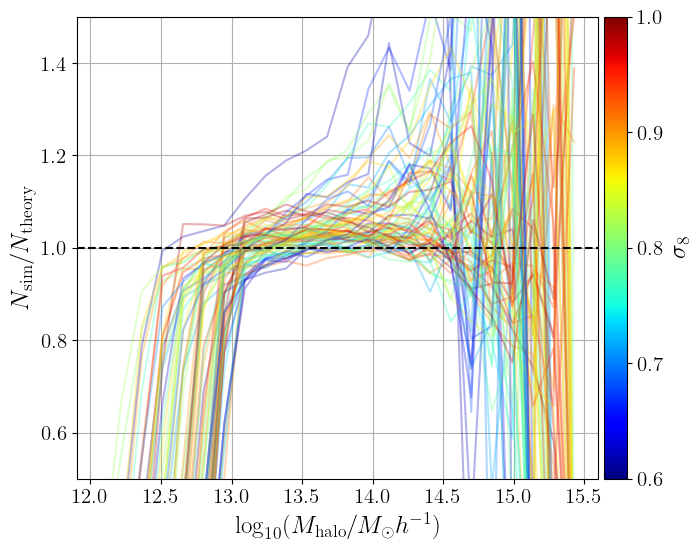

In [11]:
from tqdm import tqdm
# FOR ROCKSTAR HALOS:
root = '/mnt/home/fvillaescusa/ceph/Quijote/Snapshots/latin_hypercube_HR'
mass_types = ['rockstar_200c']
root_out = '/mnt/home/spandey/ceph/Quijote/data_NGP_self_LH'
ptypes       = [1]
BoxSize = 1000.0 #Mpc/h ; size of box
n_sim_array = np.arange(0, 80)
snap_num_array = [3]

M_array_edges = np.logspace(12.0,15.5,25)
lnM_array_edges = np.log(M_array_edges)
log10M_array_edges = np.log10(M_array_edges)
# M_cen = 0.5*(M_array_edges[1:] + M_array_edges[:-1])
# delta_M_array = M_array_edges[1:] - M_array_edges[:-1]
delta_lnM_array = lnM_array_edges[1:] - lnM_array_edges[:-1]
log10_M_cen = 0.5*(log10M_array_edges[1:] + log10M_array_edges[:-1])
# Nm_all_sim, _ = np.histogram(mhalo_sim, bins=M_array_edges)

Vol = BoxSize**3

LH_cosmo_val_file='/mnt/home/spandey/ceph/Quijote/latin_hypercube_params.txt'
LH_cosmo_val_all = np.loadtxt(LH_cosmo_val_file)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

from matplotlib import cm
norm = matplotlib.colors.Normalize(vmin=0.6, vmax=1.0)
alpha_plot = 0.5

for mass_type in mass_types:
    for ji in tqdm(n_sim_array):

        cosmo_all = LH_cosmo_val_all[ji]
        params = {'w0':-1 ,'flat': True, 'H0': cosmo_all[2]*100., 'Om0': cosmo_all[0], 'Ob0': cosmo_all[1], 'sigma8':cosmo_all[4] ,'ns': cosmo_all[3]}
        cosmology_colossus.addCosmology('myCosmo', params)
        cosmology_colossus.setCosmology('myCosmo')
        cosmo_colossus = cosmology_colossus.setCosmology('myCosmo')

        color_ji = cm.jet(norm(cosmo_all[4])) 

        for snapnum in snap_num_array:
            z = {4:0, 3:0.5, 2:1, 1:2, 0:3, -1: 127}[snapnum]



            if 'rockstar' in mass_type:
                snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/Rockstar/latin_hypercube_HR'
                snapdir = snap_dir_base + '/' + str(ji)  #folder hosting the catalogue
                rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
                with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
                    lines = f.readlines()
                header = lines[0].split()
                # get the properties of the halos
                pos_h_truth = rockstar[:,header.index('X'):header.index('Z')+1]
                if mass_type == 'rockstar_vir':
                    index_M = header.index('Mvir')                    
                    mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h

                    dndm_model = 'tinker08'
                    mdef ='vir'


                if mass_type == 'rockstar_200c':
                    index_M = header.index('M200c')                    
                    mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h

                    dndm_model = 'tinker08'
                    mdef ='200c'

            if 'fof' in mass_type:
                # snap_dir_base = '/mnt/home/spandey/ceph/Quijote/fiducial_HR_new/Halos/FoF'
                snapdir = snap_dir_base + '/' + str(ji)  #folder hosting the catalogue
                FoF = readfof.FoF_catalog(snapdir, snapnum, long_ids=False, swap=False, SFR=False, read_IDs=False)
                # get the properties of the halos
                pos_h_truth = FoF.GroupPos / 1e3  #Halo positions in Mpc/h
                mass_truth = FoF.GroupMass * 1e10  #Halo masses in Msun/h

                dndm_model = 'bhattacharya11'
                mdef ='fof'

            Nm_all_sim, _ = np.histogram(np.log(mass_truth), bins=lnM_array_edges)

            dndlnm_theory = mass_function.massFunction(10**log10_M_cen, z,
                                                        mdef=mdef, model=dndm_model,
                                                        q_out='dndlnM')

            Nm_all_theory = dndlnm_theory * delta_lnM_array * Vol

            ax.plot(log10_M_cen, Nm_all_sim/Nm_all_theory, '-', alpha=0.3, color=color_ji)

ax.set_ylim(0.5, 1.5)
ax.grid()
ax.axhline(1.0, ls='--', color='k')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_xlabel(r'$\log_{10}(M_{\rm halo}/M_{\odot}h^{-1})$', fontsize=18)
ax.set_ylabel(r'$N_{\rm sim}/N_{\rm theory}$', fontsize=18)
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.jet), ax=ax, label=r'$\sigma_8$', pad=0.01)
# set labelsize and colorbar location:
# cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r'$\sigma_8$', size=18)
cbar.set_ticks(np.arange(0.6, 1.01, 0.1))




  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_62777/888711290.py:84: RuntimeWarning: divide by zero encountered in log
  Nm_all_sim, _ = np.histogram(np.log(mass_truth), bins=lnM_array_edges)
100%|██████████| 100/100 [02:14<00:00,  1.35s/it]


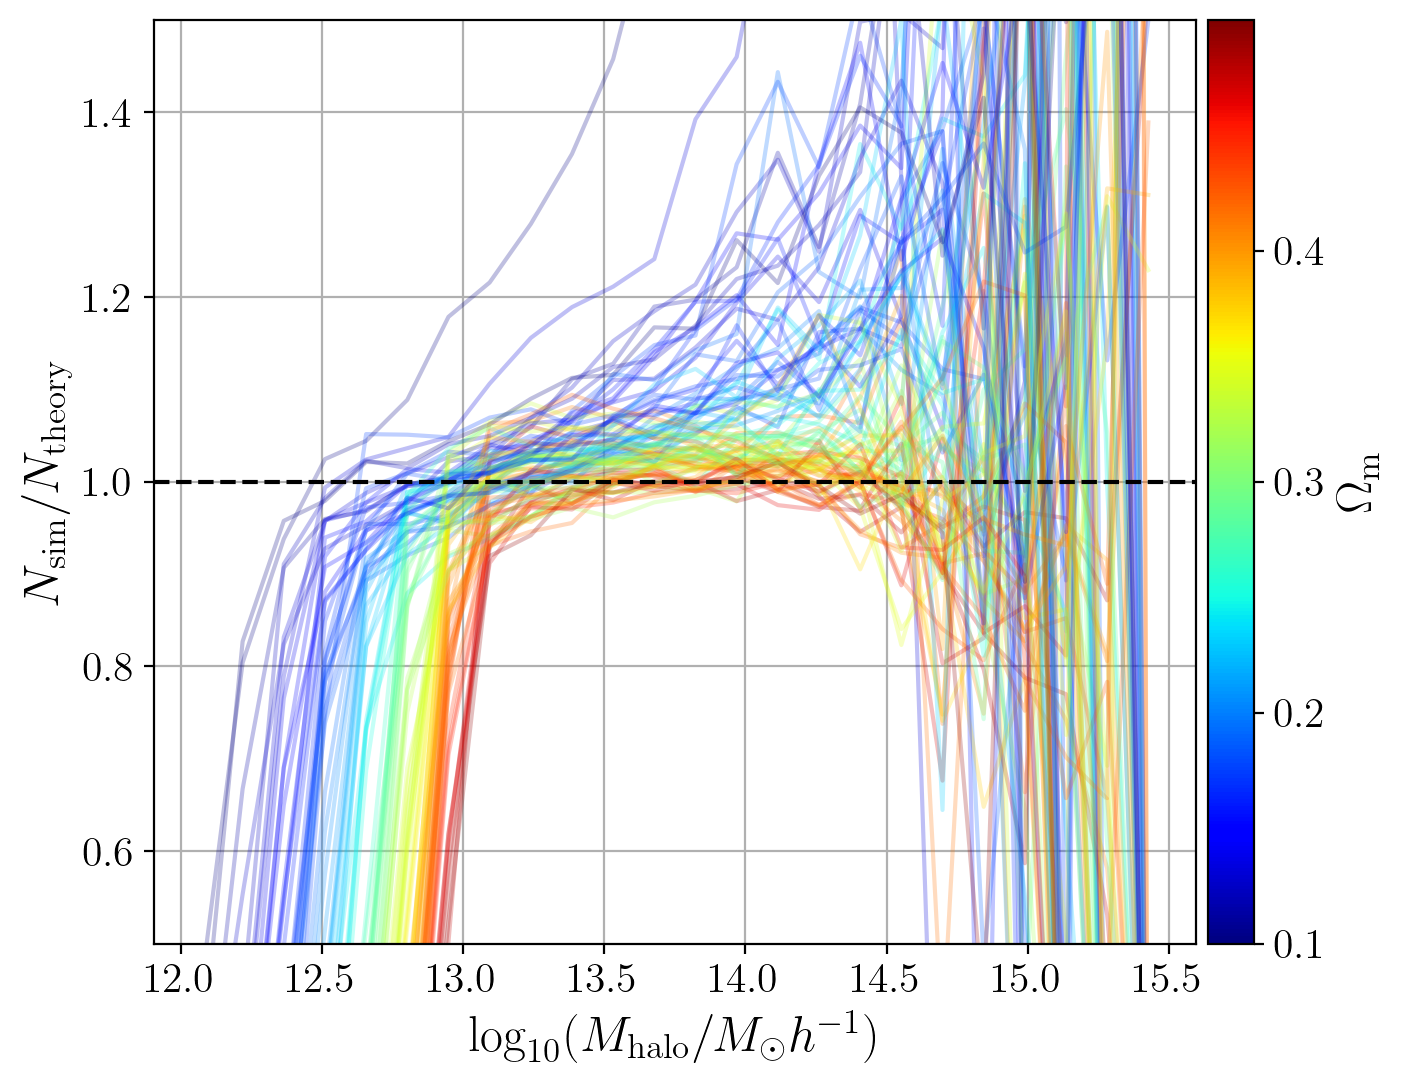

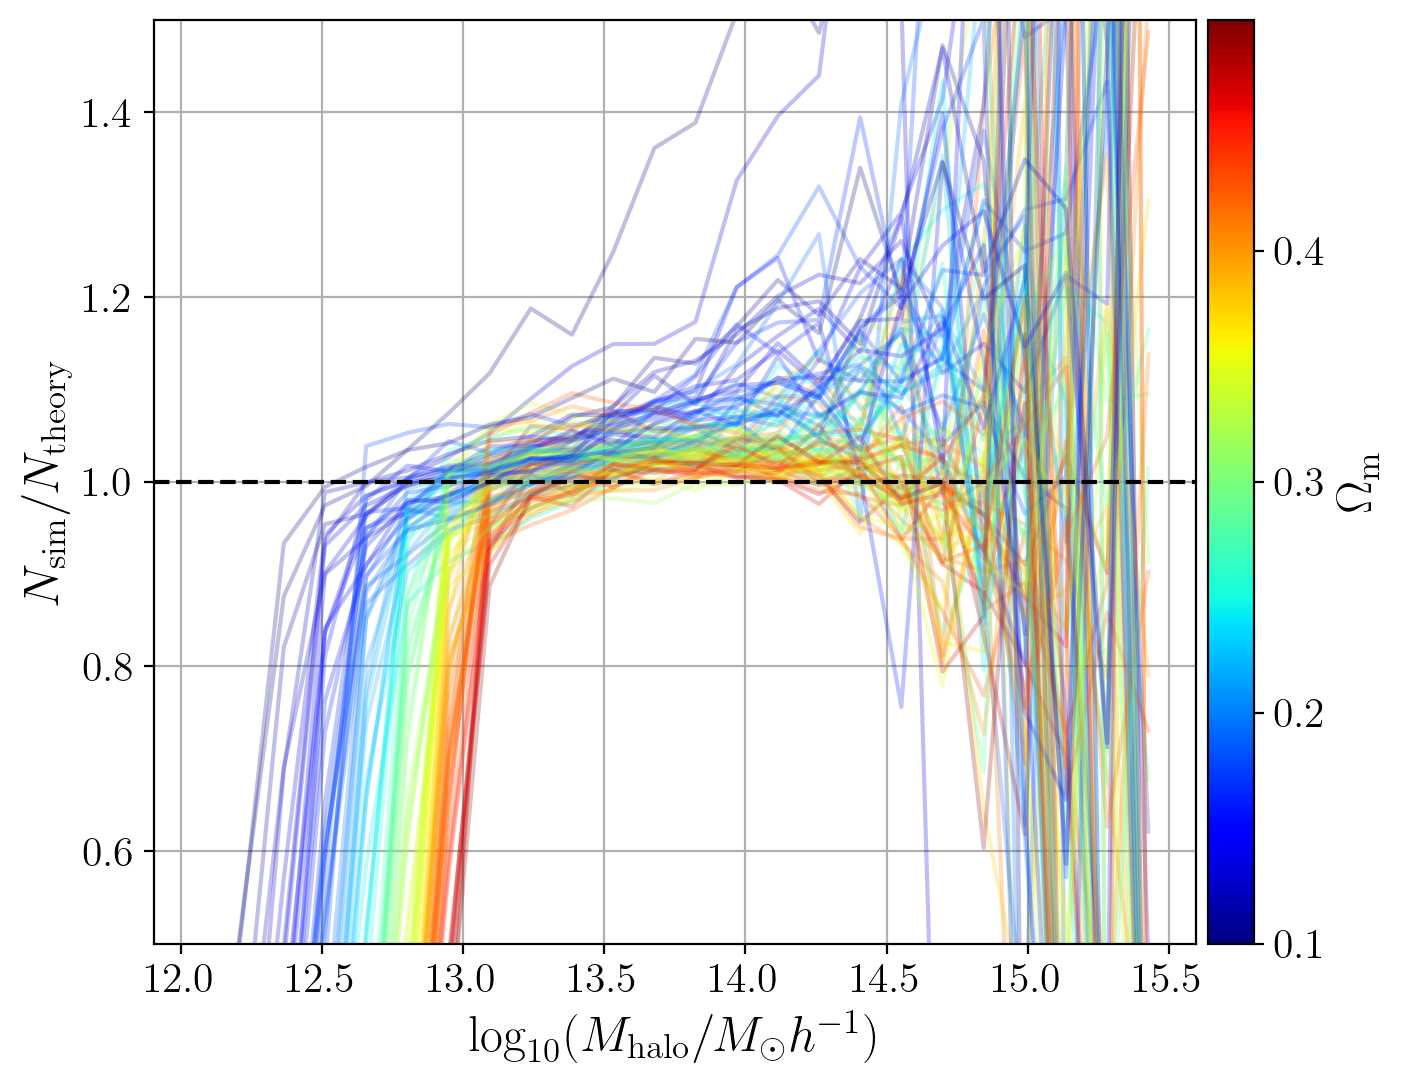

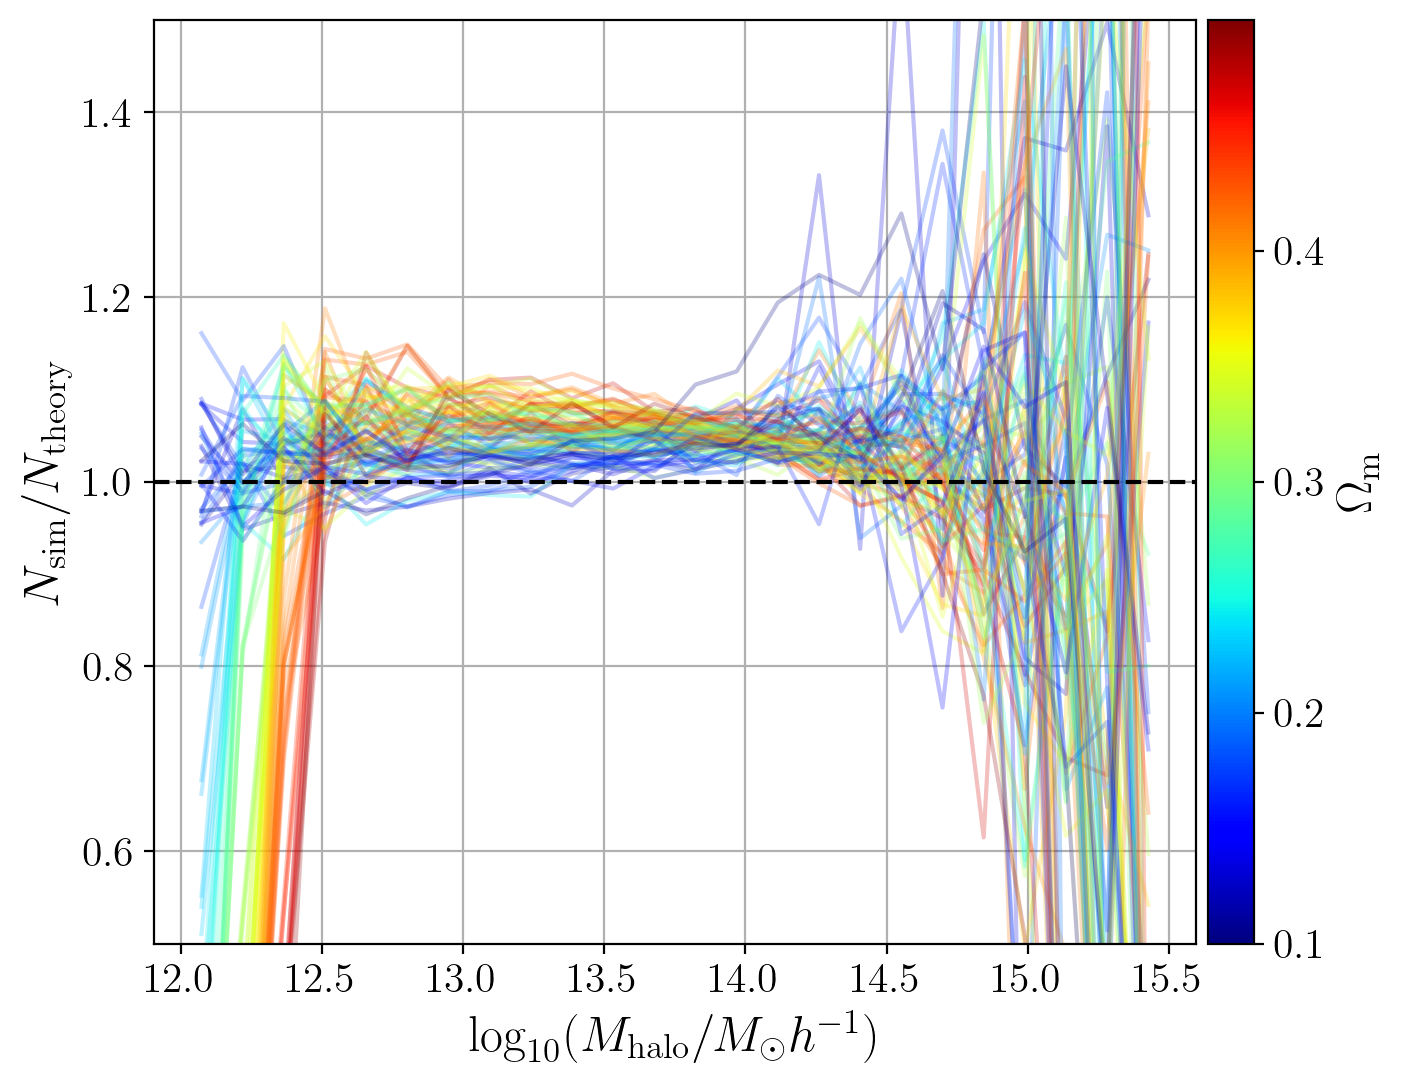

In [16]:
from tqdm import tqdm
# FOR ROCKSTAR HALOS:
root = '/mnt/home/fvillaescusa/ceph/Quijote/Snapshots/latin_hypercube_HR'
# mass_types = ['rockstar_200c']
mass_types = ['rockstar_200c', 'rockstar_vir', 'fof']
root_out = '/mnt/home/spandey/ceph/Quijote/data_NGP_self_LH'
ptypes       = [1]
BoxSize = 1000.0 #Mpc/h ; size of box
n_sim_array = np.arange(0, 100)
snap_num_array = [3]

M_array_edges = np.logspace(12.0,15.5,25)
lnM_array_edges = np.log(M_array_edges)
log10M_array_edges = np.log10(M_array_edges)
# M_cen = 0.5*(M_array_edges[1:] + M_array_edges[:-1])
# delta_M_array = M_array_edges[1:] - M_array_edges[:-1]
delta_lnM_array = lnM_array_edges[1:] - lnM_array_edges[:-1]
log10_M_cen = 0.5*(log10M_array_edges[1:] + log10M_array_edges[:-1])
# Nm_all_sim, _ = np.histogram(mhalo_sim, bins=M_array_edges)

Vol = BoxSize**3

LH_cosmo_val_file='/mnt/home/spandey/ceph/Quijote/latin_hypercube_params.txt'
LH_cosmo_val_all = np.loadtxt(LH_cosmo_val_file)

for mass_type in mass_types:

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    from matplotlib import cm
    norm = matplotlib.colors.Normalize(vmin=0.1, vmax=0.5)
    alpha_plot = 0.5

    for ji in tqdm(n_sim_array):

        cosmo_all = LH_cosmo_val_all[ji]
        params = {'w0':-1 ,'flat': True, 'H0': cosmo_all[2]*100., 'Om0': cosmo_all[0], 'Ob0': cosmo_all[1], 'sigma8':cosmo_all[4] ,'ns': cosmo_all[3]}
        cosmology_colossus.addCosmology('myCosmo', params)
        cosmology_colossus.setCosmology('myCosmo')
        cosmo_colossus = cosmology_colossus.setCosmology('myCosmo')

        color_ji = cm.jet(norm(cosmo_all[0])) 

        for snapnum in snap_num_array:
            z = {4:0, 3:0.5, 2:1, 1:2, 0:3, -1: 127}[snapnum]



            if 'rockstar' in mass_type:
                snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/Rockstar/latin_hypercube_HR'
                snapdir = snap_dir_base + '/' + str(ji)  #folder hosting the catalogue
                rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
                with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
                    lines = f.readlines()
                header = lines[0].split()
                # get the properties of the halos
                pos_h_truth = rockstar[:,header.index('X'):header.index('Z')+1]
                if mass_type == 'rockstar_vir':
                    index_M = header.index('Mvir')                    
                    mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h

                    dndm_model = 'tinker08'
                    mdef ='vir'


                if mass_type == 'rockstar_200c':
                    index_M = header.index('M200c')                    
                    mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h

                    dndm_model = 'tinker08'
                    mdef ='200c'

            if 'fof' in mass_type:
                snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/FoF/latin_hypercube_HR'
                snapdir = snap_dir_base + '/' + str(ji)  #folder hosting the catalogue
                FoF = readfof.FoF_catalog(snapdir, snapnum, long_ids=False, swap=False, SFR=False, read_IDs=False)
                # get the properties of the halos
                pos_h_truth = FoF.GroupPos / 1e3  #Halo positions in Mpc/h
                mass_truth = FoF.GroupMass * 1e10  #Halo masses in Msun/h

                dndm_model = 'bhattacharya11'
                mdef ='fof'

            Nm_all_sim, _ = np.histogram(np.log(mass_truth), bins=lnM_array_edges)

            dndlnm_theory = mass_function.massFunction(10**log10_M_cen, z,
                                                        mdef=mdef, model=dndm_model,
                                                        q_out='dndlnM')

            Nm_all_theory = dndlnm_theory * delta_lnM_array * Vol

            ax.plot(log10_M_cen, Nm_all_sim/Nm_all_theory, '-', alpha=0.25, color=color_ji)

    ax.set_ylim(0.5, 1.5)
    ax.grid()
    ax.axhline(1.0, ls='--', color='k')
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=15)
    ax.set_xlabel(r'$\log_{10}(M_{\rm halo}/M_{\odot}h^{-1})$', fontsize=18)
    ax.set_ylabel(r'$N_{\rm sim}/N_{\rm theory}$', fontsize=18)
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.jet), ax=ax, label=r'$\Omega_{\rm m}$', pad=0.01)
    # set labelsize and colorbar location:
    # cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=15)
    cbar.set_label(r'$\Omega_{\rm m}$', size=18)
    # cbar.set_ticks(np.arange(0.6, 1.01, 0.1))
    cbar.set_ticks(np.arange(0.1, 0.5, 0.1))
    fig.savefig(f'N_sim_N_theory_comp_{mass_type}.pdf', bbox_inches='tight')




In [1]:
import readgadget
import readfof
import bigfile
import nbodykit
import sys, os
import nbodykit.lab as nb
import readgadget
import numpy as np
import matplotlib.pyplot as pl
from ngp_mass import NGP_mass
import dill
from tqdm import tqdm
import sparse
import MAS_library as MASL

def save_halo_cats(isim, mass_type='fof'):
    snapnum = 3
    grid = 128
    BoxSize = 1000.
    z_dict = {4:0.0, 3:0.5, 2:1.0, 1:2.0, 0:3.0}
    redshift = z_dict[snapnum]
    # mass_type = 'rockstar_200c'


    if 'rockstar' in mass_type:
        snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/Rockstar/latin_hypercube_HR'
        verbose = False   #print information on progress
        snapdir = snap_dir_base + '/' + str(isim)  #folder hosting the catalogue
        rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
        with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
            lines = f.readlines()
        header = lines[0].split()
        # get the properties of the halos
        pos_h_truth = rockstar[:,header.index('X'):header.index('Z')+1]
        index_M = header.index('M200c')                    
        mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h
        lgMass_truth = np.log10(mass_truth).astype(np.float32)
        vel_h_truth = rockstar[:,header.index('VX'):header.index('VZ')+1]

    if 'fof' in mass_type:
        snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/FoF/latin_hypercube_HR'
        snapdir = snap_dir_base + '/' + str(isim)  #folder hosting the catalogue
        FoF = readfof.FoF_catalog(snapdir, snapnum, long_ids=False, swap=False, SFR=False, read_IDs=False)
        # get the properties of the halos
        pos_h_truth = FoF.GroupPos / 1e3  #Halo positions in Mpc/h
        mass_truth = FoF.GroupMass * 1e10  #Halo masses in Msun/h
        lgMass_truth = np.log10(mass_truth).astype(np.float32)
        vel_h_truth = FoF.GroupVel*(1.0+redshift) #Halo peculiar velocities in km/s

    Mmin_cut = 5e12
    Mmin_cut_str = '5e12'
    n_batch = 8

    root_out = '/mnt/home/spandey/ceph/Quijote/data_NGP_self_LH'
    folder_out = '%s/%d'%(root_out,isim)
    # create output folder if it does not exists
    if not(os.path.exists(folder_out)):
        os.system('mkdir %s'%folder_out)

    z = {4:0, 3:0.5, 2:1, 1:2, 0:3, -1: 127}[snapnum]
    savefname_halos_subvol = '%s/SPARSEMATS_halos_HR_%s_lgMmincut_%s_subvol_res_%d_z=%s.pk'%(folder_out,mass_type,Mmin_cut_str,grid,z)
    savefname_halos_full = '%s/SPARSEMATS_halos_HR_%s_lgMmincut_%s_full_res_%d_z=%s.pk'%(folder_out,mass_type,Mmin_cut_str,grid,z)            


    indsel = np.where(mass_truth > Mmin_cut)[0]
    pos_h_truth = pos_h_truth[indsel]
    mass_truth = mass_truth[indsel]
    lgMass_truth = lgMass_truth[indsel]
    vel_h_truth = vel_h_truth[indsel]

    from scipy.interpolate import RegularGridInterpolator
    xall = (np.linspace(0, BoxSize, grid + 1))
    xarray = 0.5 * (xall[1:] + xall[:-1])
    yarray = np.copy(xarray)
    zarray = np.copy(xarray)

    import pickle as pk
    vel_load_dir = '/mnt/home/spandey/ceph/Quijote/data_NGP_self_fastpm_LH/'
    df = pk.load(open(vel_load_dir + f'{isim}/velocity_HR_full_m_res_128_z=0.5_nbatch_8_nfilter_3_ncnn_0.pk', 'rb'))['velocity_cic_unpad_combined']
    vx_mesh_load = 1000.*df[0,...]
    vy_mesh_load = 1000.*df[1,...]
    vz_mesh_load = 1000.*df[2,...]

    vx_all_3D_interp_l = RegularGridInterpolator((xarray, yarray, zarray), vx_mesh_load, bounds_error=False, fill_value=None)
    vy_all_3D_interp_l = RegularGridInterpolator((xarray, yarray, zarray), vy_mesh_load, bounds_error=False, fill_value=None)
    vz_all_3D_interp_l = RegularGridInterpolator((xarray, yarray, zarray), vz_mesh_load, bounds_error=False, fill_value=None)

    vx_eval_interp_l = vx_all_3D_interp_l(pos_h_truth)
    vy_eval_interp_l = vy_all_3D_interp_l(pos_h_truth)
    vz_eval_interp_l = vz_all_3D_interp_l(pos_h_truth)

    vx_diff = vel_h_truth[:,0] - vx_eval_interp_l
    vy_diff = vel_h_truth[:,1] - vy_eval_interp_l
    vz_diff = vel_h_truth[:,2] - vz_eval_interp_l


    Nhalos = np.float32(np.zeros((grid, grid, grid)))
    MASL.NGP(np.float32(pos_h_truth), Nhalos, BoxSize)
    print('max number of halos:', np.amax(Nhalos))

    if grid == 64:
        nMax_h = 30  # maximum number of halos expected in a cell
    elif grid == 128:
        nMax_h = 20
    elif grid == 256:
        nMax_h = 8
    elif grid == 512:
        nMax_h = 3
    elif grid == 1024:
        nMax_h = 2
    else:
        print('nside not supported')
        sys.exit()

    dfhalo_ngp_wmass = np.float32(np.zeros((grid, grid, grid, nMax_h)))
    NGP_mass(np.float32(pos_h_truth), np.float32(lgMass_truth), dfhalo_ngp_wmass, BoxSize)

    dfhalo_ngp_wvx_true = np.float32(np.zeros((grid, grid, grid, nMax_h)))
    NGP_mass(np.float32(pos_h_truth), np.float32(vel_h_truth[:,0]), dfhalo_ngp_wvx_true, BoxSize)

    dfhalo_ngp_wvy_true = np.float32(np.zeros((grid, grid, grid, nMax_h)))
    NGP_mass(np.float32(pos_h_truth), np.float32(vel_h_truth[:,1]), dfhalo_ngp_wvy_true, BoxSize)

    dfhalo_ngp_wvz_true = np.float32(np.zeros((grid, grid, grid, nMax_h)))
    NGP_mass(np.float32(pos_h_truth), np.float32(vel_h_truth[:,2]), dfhalo_ngp_wvz_true, BoxSize)


    dfhalo_ngp_wvx_pred = np.float32(np.zeros((grid, grid, grid, nMax_h)))
    NGP_mass(np.float32(pos_h_truth), np.float32(vx_eval_interp_l), dfhalo_ngp_wvx_pred, BoxSize)

    dfhalo_ngp_wvy_pred = np.float32(np.zeros((grid, grid, grid, nMax_h)))
    NGP_mass(np.float32(pos_h_truth), np.float32(vy_eval_interp_l), dfhalo_ngp_wvy_pred, BoxSize)

    dfhalo_ngp_wvz_pred = np.float32(np.zeros((grid, grid, grid, nMax_h)))
    NGP_mass(np.float32(pos_h_truth), np.float32(vz_eval_interp_l), dfhalo_ngp_wvz_pred, BoxSize)

    argsort_M = np.flip(np.argsort(dfhalo_ngp_wmass, axis=-1), axis=-1)

    # M_halos = np.flip(np.sort(dfhalo_ngp_wmass, axis=-1), axis=-1)
    M_halos = np.take_along_axis(dfhalo_ngp_wmass, argsort_M, axis=-1)
    dfhalo_ngp_wvx_true = np.take_along_axis(dfhalo_ngp_wvx_true, argsort_M, axis=-1)
    dfhalo_ngp_wvy_true = np.take_along_axis(dfhalo_ngp_wvy_true, argsort_M, axis=-1)
    dfhalo_ngp_wvz_true = np.take_along_axis(dfhalo_ngp_wvz_true, argsort_M, axis=-1)
    dfhalo_ngp_wvx_pred = np.take_along_axis(dfhalo_ngp_wvx_pred, argsort_M, axis=-1)
    dfhalo_ngp_wvy_pred = np.take_along_axis(dfhalo_ngp_wvy_pred, argsort_M, axis=-1)
    dfhalo_ngp_wvz_pred = np.take_along_axis(dfhalo_ngp_wvz_pred, argsort_M, axis=-1)


    dfhalo_ngp_wvall_true = np.moveaxis(np.array([dfhalo_ngp_wvx_true, dfhalo_ngp_wvy_true, dfhalo_ngp_wvz_true]), 0, -1)
    dfhalo_ngp_wvall_pred = np.moveaxis(np.array([dfhalo_ngp_wvx_pred, dfhalo_ngp_wvy_pred, dfhalo_ngp_wvz_pred]), 0, -1)
    dfhalo_ngp_wvall_diff =  dfhalo_ngp_wvall_pred - dfhalo_ngp_wvall_true

    # now split it into nbatches each side

    subvol_size = grid // n_batch
    nsubvol = n_batch**3
    save_subvol_Nhalo = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
    save_subvol_Mhalo = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size, nMax_h))
    save_subvol_vtrue = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size, nMax_h, 3))
    save_subvol_vpred = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size, nMax_h, 3))
    save_subvol_vdiff = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size, nMax_h, 3))

    jc = 0
    from tqdm import tqdm
    for jx in (range(n_batch)):
        for jy in range(n_batch):
            for jz in range(n_batch):
                # get the sub-cube
                save_subvol_Nhalo[jc] = Nhalos[jx * subvol_size:(jx + 1) * subvol_size,
                                            jy * subvol_size:(jy + 1) * subvol_size,
                                            jz * subvol_size:(jz + 1) * subvol_size]
                save_subvol_Mhalo[jc] = M_halos[jx * subvol_size:(jx + 1) * subvol_size,
                                                jy * subvol_size:(jy + 1) * subvol_size,
                                                jz * subvol_size:(jz + 1) * subvol_size]

                save_subvol_vtrue[jc] = dfhalo_ngp_wvall_true[jx * subvol_size:(jx + 1) * subvol_size,
                                                jy * subvol_size:(jy + 1) * subvol_size,
                                                jz * subvol_size:(jz + 1) * subvol_size]

                save_subvol_vpred[jc] = dfhalo_ngp_wvall_pred[jx * subvol_size:(jx + 1) * subvol_size,
                                                jy * subvol_size:(jy + 1) * subvol_size,
                                                jz * subvol_size:(jz + 1) * subvol_size]

                save_subvol_vdiff[jc] = dfhalo_ngp_wvall_diff[jx * subvol_size:(jx + 1) * subvol_size,
                                                jy * subvol_size:(jy + 1) * subvol_size,
                                                jz * subvol_size:(jz + 1) * subvol_size]


                jc += 1

    save_subvol_Nhalo = sparse.COO(save_subvol_Nhalo)
    save_subvol_Mhalo = sparse.COO(save_subvol_Mhalo)
    save_subvol_vtrue = sparse.COO(save_subvol_vtrue)
    save_subvol_vpred = sparse.COO(save_subvol_vpred)
    save_subvol_vdiff = sparse.COO(save_subvol_vdiff)
    saved_halos_subvol = {
        'N_halos': save_subvol_Nhalo,
        'M_halos': save_subvol_Mhalo,
        'v_halos_true': save_subvol_vtrue,
        'v_halos_pred': save_subvol_vpred,
        'v_halos_diff': save_subvol_vdiff
        }    
    dill.dump(saved_halos_subvol, open(savefname_halos_subvol, 'wb'))

    Nhalos = sparse.COO(Nhalos)
    M_halos = sparse.COO(M_halos)
    dfhalo_ngp_wvall_true = sparse.COO(dfhalo_ngp_wvall_true)
    dfhalo_ngp_wvall_pred = sparse.COO(dfhalo_ngp_wvall_pred)
    dfhalo_ngp_wvall_diff = sparse.COO(dfhalo_ngp_wvall_diff)
    saved_halos_full = {
        'N_halos_combined': Nhalos,
        'M_halos_combined': M_halos,
        'v_halos_true_combined': dfhalo_ngp_wvall_true,
        'v_halos_pred_combined': dfhalo_ngp_wvall_pred,
        'v_halos_diff_combined': dfhalo_ngp_wvall_diff
        }    
    dill.dump(saved_halos_full, open(savefname_halos_full, 'wb'))



In [2]:
save_halo_cats(1, mass_type='fof')


max number of halos: 10.0


In [1]:
import readgadget
import readfof
import bigfile
import nbodykit
import sys, os
import nbodykit.lab as nb
import readgadget
import numpy as np
import matplotlib.pyplot as pl
from ngp_mass import NGP_mass
import dill
from tqdm import tqdm
import sparse
import MAS_library as MASL

def save_halo_cats(isim, mass_type='fof'):
    snapnum = 3
    grid = 128
    BoxSize = 1000.
    z_dict = {4:0.0, 3:0.5, 2:1.0, 1:2.0, 0:3.0}
    redshift = z_dict[snapnum]
    # mass_type = 'rockstar_200c'


    if 'rockstar' in mass_type:
        # snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/Rockstar/latin_hypercube_HR'
        snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/Rockstar/fiducial_HR'        
        verbose = False   #print information on progress
        snapdir = snap_dir_base + '/' + str(isim)  #folder hosting the catalogue
        rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
        with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
            lines = f.readlines()
        header = lines[0].split()
        # get the properties of the halos
        pos_h_truth = rockstar[:,header.index('X'):header.index('Z')+1]
        index_M = header.index('M200c')                    
        mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h
        lgMass_truth = np.log10(mass_truth).astype(np.float32)
        vel_h_truth = rockstar[:,header.index('VX'):header.index('VZ')+1]

    if 'fof' in mass_type:
        # snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/FoF/latin_hypercube_HR'
        snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/FoF/fiducial_HR'        
        snapdir = snap_dir_base + '/' + str(isim)  #folder hosting the catalogue
        FoF = readfof.FoF_catalog(snapdir, snapnum, long_ids=False, swap=False, SFR=False, read_IDs=False)
        # get the properties of the halos
        pos_h_truth = FoF.GroupPos / 1e3  #Halo positions in Mpc/h
        mass_truth = FoF.GroupMass * 1e10  #Halo masses in Msun/h
        lgMass_truth = np.log10(mass_truth).astype(np.float32)
        vel_h_truth = FoF.GroupVel*(1.0+redshift) #Halo peculiar velocities in km/s

    Mmin_cut = 5e12
    Mmin_cut_str = '5e12'
    n_batch = 8

    # root_out = '/mnt/home/spandey/ceph/Quijote/data_NGP_self_LH'
    root_out = '/mnt/home/spandey/ceph/Quijote/data_NGP_self'    
    folder_out = '%s/%d'%(root_out,isim)
    # create output folder if it does not exists
    if not(os.path.exists(folder_out)):
        os.system('mkdir %s'%folder_out)

    z = {4:0, 3:0.5, 2:1, 1:2, 0:3, -1: 127}[snapnum]
    savefname_halos_subvol = '%s/SPARSEMATS_halos_HR_%s_lgMmincut_%s_subvol_res_%d_z=%s.pk'%(folder_out,mass_type,Mmin_cut_str,grid,z)
    savefname_halos_full = '%s/SPARSEMATS_halos_HR_%s_lgMmincut_%s_full_res_%d_z=%s.pk'%(folder_out,mass_type,Mmin_cut_str,grid,z)            


    indsel = np.where(mass_truth > Mmin_cut)[0]
    pos_h_truth = pos_h_truth[indsel]
    mass_truth = mass_truth[indsel]
    lgMass_truth = lgMass_truth[indsel]
    vel_h_truth = vel_h_truth[indsel]

    from scipy.interpolate import RegularGridInterpolator
    xall = (np.linspace(0, BoxSize, grid + 1))
    xarray = 0.5 * (xall[1:] + xall[:-1])
    yarray = np.copy(xarray)
    zarray = np.copy(xarray)

    import pickle as pk
    # vel_load_dir = '/mnt/home/spandey/ceph/Quijote/data_NGP_self_fastpm_LH/'
    vel_load_dir = '/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm/'    
    df = pk.load(open(vel_load_dir + f'{isim}/velocity_HR_full_m_res_128_z=0.5_nbatch_8_nfilter_3_ncnn_0.pk', 'rb'))['velocity_cic_unpad_combined']
    vx_mesh_load = 1000.*df[0,...]
    vy_mesh_load = 1000.*df[1,...]
    vz_mesh_load = 1000.*df[2,...]

    vx_all_3D_interp_l = RegularGridInterpolator((xarray, yarray, zarray), vx_mesh_load, bounds_error=False, fill_value=None)
    vy_all_3D_interp_l = RegularGridInterpolator((xarray, yarray, zarray), vy_mesh_load, bounds_error=False, fill_value=None)
    vz_all_3D_interp_l = RegularGridInterpolator((xarray, yarray, zarray), vz_mesh_load, bounds_error=False, fill_value=None)

    vx_eval_interp_l = vx_all_3D_interp_l(pos_h_truth)
    vy_eval_interp_l = vy_all_3D_interp_l(pos_h_truth)
    vz_eval_interp_l = vz_all_3D_interp_l(pos_h_truth)

    vx_diff = vel_h_truth[:,0] - vx_eval_interp_l
    vy_diff = vel_h_truth[:,1] - vy_eval_interp_l
    vz_diff = vel_h_truth[:,2] - vz_eval_interp_l


    Nhalos = np.float32(np.zeros((grid, grid, grid)))
    MASL.NGP(np.float32(pos_h_truth), Nhalos, BoxSize)
    print('max number of halos:', np.amax(Nhalos))

    if grid == 64:
        nMax_h = 30  # maximum number of halos expected in a cell
    elif grid == 128:
        nMax_h = 20
    elif grid == 256:
        nMax_h = 8
    elif grid == 512:
        nMax_h = 3
    elif grid == 1024:
        nMax_h = 2
    else:
        print('nside not supported')
        sys.exit()

    dfhalo_ngp_wmass = np.float32(np.zeros((grid, grid, grid, nMax_h)))
    NGP_mass(np.float32(pos_h_truth), np.float32(lgMass_truth), dfhalo_ngp_wmass, BoxSize)

    dfhalo_ngp_wvx_true = np.float32(np.zeros((grid, grid, grid, nMax_h)))
    NGP_mass(np.float32(pos_h_truth), np.float32(vel_h_truth[:,0]), dfhalo_ngp_wvx_true, BoxSize)

    dfhalo_ngp_wvy_true = np.float32(np.zeros((grid, grid, grid, nMax_h)))
    NGP_mass(np.float32(pos_h_truth), np.float32(vel_h_truth[:,1]), dfhalo_ngp_wvy_true, BoxSize)

    dfhalo_ngp_wvz_true = np.float32(np.zeros((grid, grid, grid, nMax_h)))
    NGP_mass(np.float32(pos_h_truth), np.float32(vel_h_truth[:,2]), dfhalo_ngp_wvz_true, BoxSize)


    dfhalo_ngp_wvx_pred = np.float32(np.zeros((grid, grid, grid, nMax_h)))
    NGP_mass(np.float32(pos_h_truth), np.float32(vx_eval_interp_l), dfhalo_ngp_wvx_pred, BoxSize)

    dfhalo_ngp_wvy_pred = np.float32(np.zeros((grid, grid, grid, nMax_h)))
    NGP_mass(np.float32(pos_h_truth), np.float32(vy_eval_interp_l), dfhalo_ngp_wvy_pred, BoxSize)

    dfhalo_ngp_wvz_pred = np.float32(np.zeros((grid, grid, grid, nMax_h)))
    NGP_mass(np.float32(pos_h_truth), np.float32(vz_eval_interp_l), dfhalo_ngp_wvz_pred, BoxSize)

    argsort_M = np.flip(np.argsort(dfhalo_ngp_wmass, axis=-1), axis=-1)

    # M_halos = np.flip(np.sort(dfhalo_ngp_wmass, axis=-1), axis=-1)
    M_halos = np.take_along_axis(dfhalo_ngp_wmass, argsort_M, axis=-1)
    dfhalo_ngp_wvx_true = np.take_along_axis(dfhalo_ngp_wvx_true, argsort_M, axis=-1)
    dfhalo_ngp_wvy_true = np.take_along_axis(dfhalo_ngp_wvy_true, argsort_M, axis=-1)
    dfhalo_ngp_wvz_true = np.take_along_axis(dfhalo_ngp_wvz_true, argsort_M, axis=-1)
    dfhalo_ngp_wvx_pred = np.take_along_axis(dfhalo_ngp_wvx_pred, argsort_M, axis=-1)
    dfhalo_ngp_wvy_pred = np.take_along_axis(dfhalo_ngp_wvy_pred, argsort_M, axis=-1)
    dfhalo_ngp_wvz_pred = np.take_along_axis(dfhalo_ngp_wvz_pred, argsort_M, axis=-1)


    dfhalo_ngp_wvall_true = np.moveaxis(np.array([dfhalo_ngp_wvx_true, dfhalo_ngp_wvy_true, dfhalo_ngp_wvz_true]), 0, -1)
    dfhalo_ngp_wvall_pred = np.moveaxis(np.array([dfhalo_ngp_wvx_pred, dfhalo_ngp_wvy_pred, dfhalo_ngp_wvz_pred]), 0, -1)
    dfhalo_ngp_wvall_diff =  dfhalo_ngp_wvall_pred - dfhalo_ngp_wvall_true

    # now split it into nbatches each side

    subvol_size = grid // n_batch
    nsubvol = n_batch**3
    save_subvol_Nhalo = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
    save_subvol_Mhalo = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size, nMax_h))
    save_subvol_vtrue = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size, nMax_h, 3))
    save_subvol_vpred = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size, nMax_h, 3))
    save_subvol_vdiff = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size, nMax_h, 3))

    jc = 0
    from tqdm import tqdm
    for jx in (range(n_batch)):
        for jy in range(n_batch):
            for jz in range(n_batch):
                # get the sub-cube
                save_subvol_Nhalo[jc] = Nhalos[jx * subvol_size:(jx + 1) * subvol_size,
                                            jy * subvol_size:(jy + 1) * subvol_size,
                                            jz * subvol_size:(jz + 1) * subvol_size]
                save_subvol_Mhalo[jc] = M_halos[jx * subvol_size:(jx + 1) * subvol_size,
                                                jy * subvol_size:(jy + 1) * subvol_size,
                                                jz * subvol_size:(jz + 1) * subvol_size]

                save_subvol_vtrue[jc] = dfhalo_ngp_wvall_true[jx * subvol_size:(jx + 1) * subvol_size,
                                                jy * subvol_size:(jy + 1) * subvol_size,
                                                jz * subvol_size:(jz + 1) * subvol_size]

                save_subvol_vpred[jc] = dfhalo_ngp_wvall_pred[jx * subvol_size:(jx + 1) * subvol_size,
                                                jy * subvol_size:(jy + 1) * subvol_size,
                                                jz * subvol_size:(jz + 1) * subvol_size]

                save_subvol_vdiff[jc] = dfhalo_ngp_wvall_diff[jx * subvol_size:(jx + 1) * subvol_size,
                                                jy * subvol_size:(jy + 1) * subvol_size,
                                                jz * subvol_size:(jz + 1) * subvol_size]


                jc += 1

    save_subvol_Nhalo = sparse.COO(save_subvol_Nhalo)
    save_subvol_Mhalo = sparse.COO(save_subvol_Mhalo)
    save_subvol_vtrue = sparse.COO(save_subvol_vtrue)
    save_subvol_vpred = sparse.COO(save_subvol_vpred)
    save_subvol_vdiff = sparse.COO(save_subvol_vdiff)
    saved_halos_subvol = {
        'N_halos': save_subvol_Nhalo,
        'M_halos': save_subvol_Mhalo,
        'v_halos_true': save_subvol_vtrue,
        'v_halos_pred': save_subvol_vpred,
        'v_halos_diff': save_subvol_vdiff
        }    
    dill.dump(saved_halos_subvol, open(savefname_halos_subvol, 'wb'))

    Nhalos = sparse.COO(Nhalos)
    M_halos = sparse.COO(M_halos)
    dfhalo_ngp_wvall_true = sparse.COO(dfhalo_ngp_wvall_true)
    dfhalo_ngp_wvall_pred = sparse.COO(dfhalo_ngp_wvall_pred)
    dfhalo_ngp_wvall_diff = sparse.COO(dfhalo_ngp_wvall_diff)
    saved_halos_full = {
        'N_halos_combined': Nhalos,
        'M_halos_combined': M_halos,
        'v_halos_true_combined': dfhalo_ngp_wvall_true,
        'v_halos_pred_combined': dfhalo_ngp_wvall_pred,
        'v_halos_diff_combined': dfhalo_ngp_wvall_diff
        }    
    dill.dump(saved_halos_full, open(savefname_halos_full, 'wb'))



In [4]:
save_halo_cats(2)



max number of halos: 15.0
